# Data from Cassini frame to a Saturn centered frame

Here we transform the data from the Cassini spacecraft (SC) reference frame to a Saturn centered frame. This is done in order to use the data measured by the tri-axial search coil magnetic antennas (SCM). We use use in particular two main coordinate systems:
The spacecraft coordinate system (SC) and the Saturn Solar Ecliptic coordinate system (SSE) which is the same as the Kronian Solar Orbital (KSO).

## Coordinate systems

### 1.  Spacecraft coordinate system (SC)

This coordinate system is fixed relative to the Cassini spacecraft. It is therefore in constant motion as Cassini adjusts its pointing. The coordinate system is useful when comparing measurements
between different instruments, especially when studying the pitch angle distributions of particles
(relative to the local magnetic field vector). This should not be used for spacecraft trajectory, only
for referencing vector field directions.

__X__  is in the opposite direction to the MIMI CHEMS, INMS and RPWS Langmuir Field Of View (FOV)  
__Y__  is in the opposite direction to the FOV of the ORS instruments  
__Z__  points in the opposite direction of the High Gain Antenna  


![alt text](./Figures/Cassini_sc.png "Title")


* __PS:__ The three axes of the SCM are aligned with the x, y, and z axes of the spacecraft [[Gurnett et al., SSR, 2004]][1].
[1]: http://dx.doi.org/10.1007/s11214-004-1434-0

### 2. Saturn Solar Ecliptic coordinate system (SSE) or Kronian Solar Orbital (KSO)

This coordinate system will be similar to the GSE (Geocentric Solar Ecliptic) coordinate system used at Earth.

__X__ Points from Saturn to the Sun  
__Y__ Lies in Saturn's orbital plane pointing in the direction opposite Saturn's motion (towards dusk)  
__Z = X x Y__ Perpendicular to the plane of Saturn's motion in the Northward sense 

![alt text](./Figures/SSE_sc.png "Title2")


In [1]:
import numpy as np
import spiceypy as spice
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import datetime
import pandas as pds
import time
from dateutil import parser
plt.rcParams['figure.figsize'] = (14, 8)

## Reading the magnetic field data functions

In [2]:
# Read the magnetic field vector from file, where the Time vector is written in the format: '%Y %m %d %H %M %S'
# e.g.: 2007 12 12 00 00 00

def readMagFile(file,columns=["Bx","By","Bz"]):
    parse = lambda a,b,c,d,e,f: datetime.datetime.strptime(' '.join([a,b,c,d,e,f]), '%Y %m %d %H %M %S')
    df_B=pds.read_csv(file,delim_whitespace=True,header=None,parse_dates = [[0,1,2,3,4,5]],
                      index_col=0 , date_parser=parse)
    df_B.index.name="Time"
    df_B.columns=columns
    df_B[df_B>=100]= float('NaN')
    df_B[df_B<=-100]= float('NaN')
    df_B.interpolate(inplace=True)
    return df_B

# Read the magnetic field vector from file, where the Time vector is written in the format: '%Y%m%dT%H:%M:%S'
# e.g.: 2007-12-12T00:00:00 
# This Time format is transparent to the "pds.read_csv", one has to add the parse_dates=[0] so that the the first 
# colomn is read as a Time.

def readMagFile_AMDA(file,columns=["Bx","By","Bz"]):
    df_B=pds.read_csv(file,header=0,delim_whitespace=True,skiprows=2,index_col=0,parse_dates=[0])
    df_B.index.name="Time"
    df_B.columns=columns
    df_B[df_B>=100]= float('NaN')
    df_B[df_B<=-100]= float('NaN')
    df_B.interpolate(inplace=True)
    #df_B.resample("0.25S",fill_method='bfill')
    return df_B

## Matrix transform functions

### 1.  read_cassini_attitude_matrices:

This function reads the CASSINI spacecraft attitude file where the three main axis of the spacecraft are expressed in the SSE coordinate system for each given time.

\begin{align}
\mathbf{\hat X_{SC}} & = a_{11}\mathbf{\hat X_{SSE}} + a_{12}\mathbf{\hat Y_{SSE}} + a_{13}\mathbf{\hat Z_{SSE}} \\
\mathbf{\hat Y_{SC}} & = a_{21}\mathbf{\hat X_{SSE}} + a_{22}\mathbf{\hat Y_{SSE}} + a_{23}\mathbf{\hat Z_{SSE}} \\
\mathbf{\hat Z_{SC}} & = a_{31}\mathbf{\hat X_{SSE}} + a_{32}\mathbf{\hat Y_{SSE}} + a_{33}\mathbf{\hat Z_{SSE}}  
\end{align}



To download this file, we have to go to the [CASSINI Spacecraft Attitude tool][2]. We choose the *"Time Range"*, 
*"Time Interval"*, and __SSE Spacecraft Axes (SSE)__ for the *"Attitude Type"*.

[2]:http://cassini.physics.uiowa.edu/~tfa/cassatt.html


### 2.  transform_matt:

This function transforms the data from the SC reference frame to the SSE (or KSO) reference frame

### 3.  transform_spice:

This function uses [spiceypy](http://spiceypy.readthedocs.io/en/master/index.html) to transform the data from the SSE (or KSO) reference frame to any other reference frame (KSM, KRTP, RTN).  
  
  
We will need to load some kernels. You will need to download the following kernels (that indicate the position of the satellite, its orientation ...etc)  
from the [NAIF servers](https://naif.jpl.nasa.gov/pub/naif/CASSINI/kernels/). We need to download four types of files:  

* __*.tls.pc__   gives information regarding the planet (radius, ...)
* __*.bsp__ provides the ephemeris of Saturn and its moon
* __sat138.bsp__ provides the ephemeris of CASSINI and orientation
* __*.tpc__ gives the time base
* __*.tf__ descibes the different coordinate systems

After the kernels have been downloaded to a common directory write a metakernel containing the file names for each downloaded kernel. I named the metakernel "./Kernel_to_load_CASSINI.txt" for this example. For more on defining meta kernels in spice, please consult the [Spice Kernel Required Reading](https://naif.jpl.nasa.gov/pub/naif/toolkit_docs/C/req/kernel.html). For each case study we have to change at least the CASSINI kernel  __*.bsp__ .  


----
Kernel_to_load_CASSINI.txt content:
```
\begindata
KERNELS_TO_LOAD=('./lsk/naif0010.tls.pc', 
                 './spk/080307R_SCPSE_07345_07365.bsp',
   		         './pck/cpck27Nov2007.tpc',
                 './spk/sat138.bsp',
                 './cas_dyn_v02.tf')
\begintext
```
-----




In [3]:
def read_cassini_attitude_matrices(file):
    with open(file) as SC_ATTITUDE:
        lines = SC_ATTITUDE.readlines()
        block_count = int((len(lines)-2)/4)
        pattern = '%Y-%jT%H:%M:%S.000'
        time_vect=np.empty(block_count, dtype=object)
        attitude_vect=np.empty(block_count, dtype=object)
        for i in range(block_count):
            attitude_matrice=np.zeros((3,3))
            offset=i*4+2
            colls=lines[offset].split()
            time_vect[i]=datetime.datetime.strptime(colls[0],pattern)
            attitude_matrice[0]=[float(val) for val in colls[1:]]
            for line in range(1,3):
                attitude_matrice[line]=[ float(val) for val in lines[offset+line].split() ]
            attitude_vect[i]=attitude_matrice
    return time_vect,attitude_vect

def transform_matt(df,time_vect,attitude_vect,backward=False):
    result=np.zeros((df.shape[0],3))
    inputmat=df.values
    idx=0
    for i,t in zip(range(df.shape[0]),df.index):
        idx = np.searchsorted(time_vect[idx:],t)
        xform=attitude_vect[idx]
        if backward:
            xform = np.linalg.inv(xform)
        result[i,:]=xform.dot(np.atleast_2d(inputmat[i]).transpose())[:,0]
    return pds.DataFrame(result,columns=df.columns, index=df.index)

def transform_spice(fromstr, tostr, df,backward=False):
    result=np.zeros((df.shape[0],3))
    inputmat=df.as_matrix(df.columns)
    for i in np.arange(df.shape[0]):
        et=spice.str2et(str(df.index[i]))
        xform=spice.pxform(fromstr, tostr, et)
        if backward:
            xform = np.linalg.inv(xform)
        result[i,:]=xform.dot(np.atleast_2d(inputmat[i]).transpose())[:,0]
    return pds.DataFrame(result,columns=df.columns, index=df.index)

spice.furnsh("./Kernel_to_load_CASSINI.txt")

##  Load SC to SSE transform matrices 

In [4]:
time_vect,attitude_vect=read_cassini_attitude_matrices("./SC_SSE.txt")

## Read the FGM KSO (SSE) Data

In [5]:
B_FGM_KSO=readMagFile("./CASS_B_KSO1S.txt") 

##  From KSO to SC

In [6]:
B_FGM_SC=transform_matt(B_FGM_KSO,time_vect,attitude_vect,backward=True)

## Let's go back to SSE (KSO) and compare results 

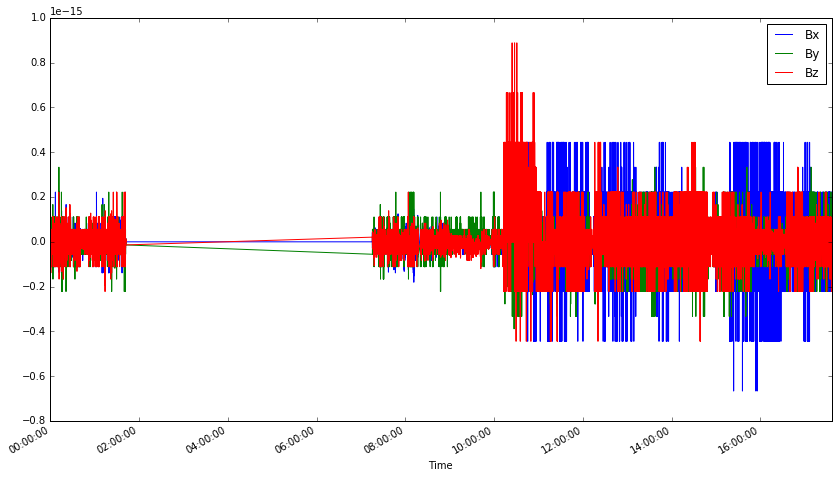

In [7]:
B_FGM_KSO_bis=transform_matt(B_FGM_SC,time_vect,attitude_vect,backward=False)
(B_FGM_KSO-B_FGM_KSO_bis).plot()

##  Let's move from SEE (KSO) to KRTP

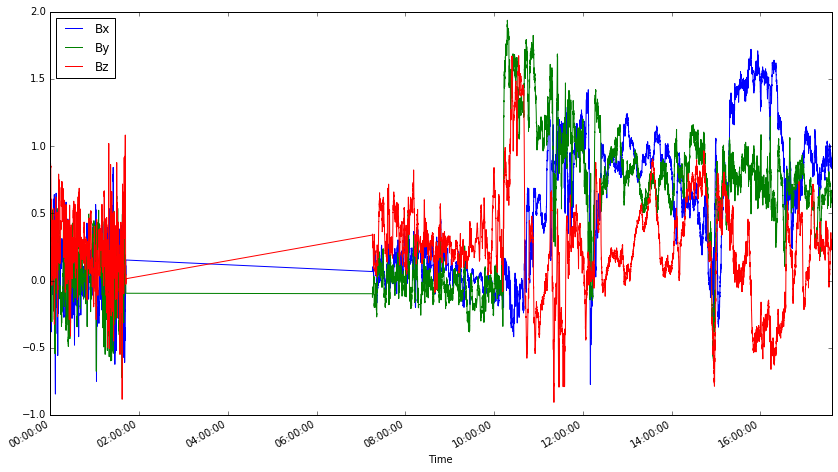

In [8]:
B_FGM_KRTP= transform_spice('CASSINI_KSO', 'CASSINI_KRTP',B_FGM_KSO)
B_FGM_KRTP.plot()

## Test: Comparison with KRTP data from AMDA

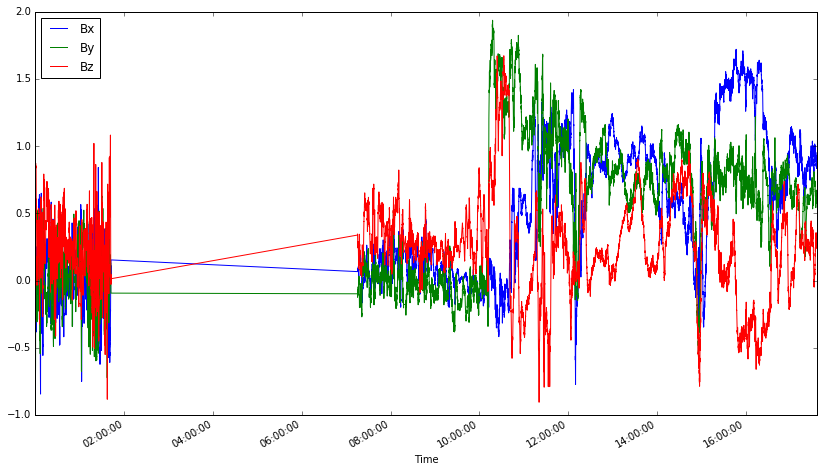

In [9]:
B_FGM_KRTP_AMDA=readMagFile_AMDA("./CASS_B_KRTP1S.txt") 
B_FGM_KRTP_AMDA.plot()

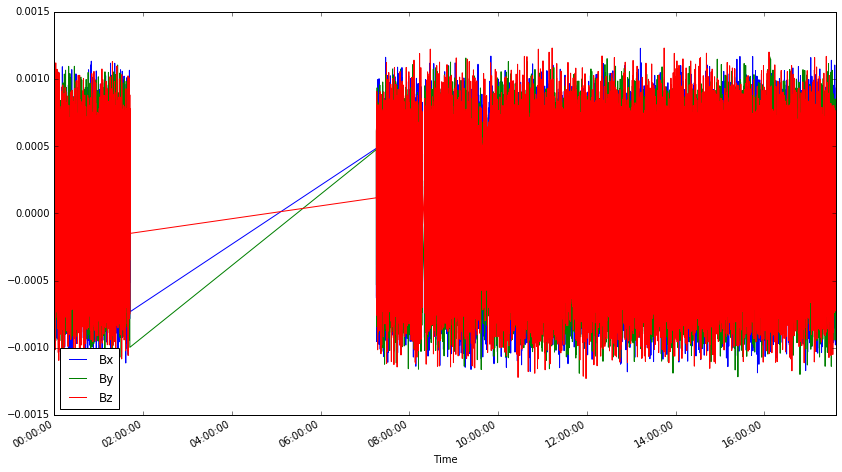

In [10]:
(B_FGM_KRTP-B_FGM_KRTP_AMDA).plot()